In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# LOAD THE DATA
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

# PREPARE DATA FOR NEURAL NETWORK
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

# GLOBAL VARIABLES
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

Using TensorFlow backend.


In [3]:

nets = 3
model = [0] *nets

for j in range(3):
    model[j] = Sequential()
    model[j].add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
            input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    if j>0:
        model[j].add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D())
    if j>1:
        model[j].add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D(padding='same'))
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [4]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333)
# TRAIN NETWORKS
history = [0] * nets
names = ["(C-P)x1","(C-P)x2","(C-P)x3"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN (C-P)x1: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.98827
CNN (C-P)x2: Epochs=20, Train accuracy=0.99996, Validation accuracy=0.99121
CNN (C-P)x3: Epochs=20, Train accuracy=0.99989, Validation accuracy=0.99199


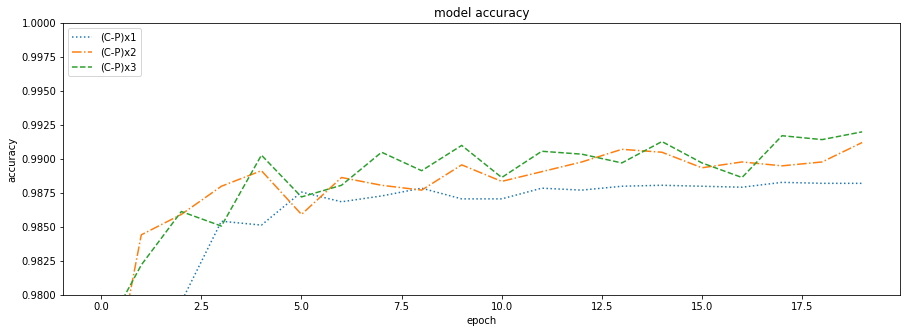

In [5]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

In [8]:
# SUBMIT TO KAGGLE
results = model[0].predict(X_test)
results = np.argmax(results,axis = 1)
print(results)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN.csv",index=False)

[2 0 9 ... 3 9 2]
